In [1]:
#%pip install --upgrade "kaleido==0.1.*"



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 MB 10.4 MB/s eta 0:00:00




In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import pandas as pd
from tqdm import tqdm
from functools import partial, reduce
from itertools import chain
import statsmodels.stats.inter_rater as ir
import scipy.stats as stats
import numpy as np
import plotly.express as px
import glob
from collections import defaultdict
import kaleido
from typing import List

# with open('/content/drive/My Drive/foo.txt', 'w') as f:
  # f.write('Hello Google Drive!')

# Loading and Combining Reviews

In [3]:

models_map = {
    'answer_gpt4': 'gpt-4',
    'answer_gpt35': 'gpt-3.5',
    'answer_bard': 'bard',
    'answer_claude': 'claude',
    'answer_vicuna-13b': 'vicuna',
}
reviewers_map = {
    'gpt4': 'gpt-4',
    'gpt35': 'gpt-3.5',
    'bard': 'bard',
    'claude': 'claude',
    'vicuna-13b': 'vicuna',
}


In [4]:
def review_filename(modelA, modelB, reviewer):
    name = f'{modelA}-vs-{modelB}-{reviewer}-reviewer*.jsonl'
    glob_path = '../data/vicuna80/ratings-*/' + name
    print(glob_path)
    globs = glob.glob(glob_path)
    return globs[0] if len(globs) > 0 else None

def format_df(df):
    # map A wins to -1, B wins to 1, and ties to 0
    df.score = df.score.map({-1: 0, 1: -1, 2: 1, 3: 0})
    df.sort_values(by='question_id', inplace=True)

def load_reviews(models_map, reviewers_map):
    dfs_list = []
    for modelA in models_map.keys():
        for modelB in models_map.keys():
            if modelA == modelB:
                continue

            for reviewer in reviewers_map.keys():
                filename = review_filename(modelA, modelB, reviewer)
                if filename is None:
                    print(f'No review file for {modelA} vs {modelB} by {reviewer}')
                    continue
                # get df and add to array
                df = pd.read_json(filename, lines=True)[['question_id', 'score']]
                format_df(df)
                invalid = df.score.isna()
                ninvalid = invalid.sum()
                if ninvalid > 0:
                    print(ninvalid, f'#invalid. {modelA} vs {modelB} by {reviewer}')
                    print(df[invalid])
                df['model_a'] = models_map[modelA]
                df['model_b'] = models_map[modelB]
                df['reviewer'] = reviewers_map[reviewer]
                dfs_list.append(df)

    # combine all dfs and shuffle
    reviews = pd.concat(dfs_list).sample(frac=1, random_state=42)
    return reviews

In [5]:
# if there are multiple reviews for a question from a given review, take the majority vote
def human_majority(df):
    def take_majority(frame):
        x = frame.mean()
        return np.sign(x)

    return df.groupby(['question_id', 'model_a', 'model_b', 'reviewer'], as_index=False).agg({'score': take_majority})

In [6]:
def filter_reviews_by_reviewers(reviews, reviewers):
    return reviews[reviews.reviewer.isin(reviewers)]
def filter_reviews_by_models(reviews, models):
    return reviews[reviews.model_a.isin(models) & reviews.model_b.isin(models)]

In [7]:
auto_reviews = load_reviews(models_map, reviewers_map)
human_reviews = human_majority(load_reviews(models_map, {'human': 'human'}))
gpt4_reviews = auto_reviews[auto_reviews.reviewer == 'gpt-4']

./ratings-*/answer_gpt4-vs-answer_gpt35-gpt-4-reviewer*.jsonl

./ratings-*/answer_gpt4-vs-answer_gpt35-gpt-3.5-turbo-0301-reviewer*.jsonl

./ratings-*/answer_gpt4-vs-answer_gpt35-text-bison@001-reviewer*.jsonl

./ratings-*/answer_gpt4-vs-answer_gpt35-claude-1-reviewer*.jsonl

./ratings-*/answer_gpt4-vs-answer_gpt35-vicuna-13b-reviewer*.jsonl

./ratings-*/answer_gpt4-vs-answer_bard-gpt-4-reviewer*.jsonl

./ratings-*/answer_gpt4-vs-answer_bard-gpt-3.5-turbo-0301-reviewer*.jsonl

./ratings-*/answer_gpt4-vs-answer_bard-text-bison@001-reviewer*.jsonl

./ratings-*/answer_gpt4-vs-answer_bard-claude-1-reviewer*.jsonl

./ratings-*/answer_gpt4-vs-answer_bard-vicuna-13b-reviewer*.jsonl

./ratings-*/answer_gpt4-vs-answer_claude-gpt-4-reviewer*.jsonl

./ratings-*/answer_gpt4-vs-answer_claude-gpt-3.5-turbo-0301-reviewer*.jsonl

./ratings-*/answer_gpt4-vs-answer_claude-text-bison@001-reviewer*.jsonl

./ratings-*/answer_gpt4-vs-answer_claude-claude-1-reviewer*.jsonl

./ratings-*/answer_gpt4-vs-answer_

In [8]:
human_copy = human_reviews.copy()
# switch model_a and model_b
human_copy['model_a'], human_copy['model_b'] = human_copy['model_b'], human_copy['model_a']
human_copy['score'] = -human_copy['score']

doubled_human_reviews = pd.concat([human_reviews, human_copy])

In [9]:
print(auto_reviews.index.size, human_reviews.index.size, gpt4_reviews.index.size)

8000 800 1600


# Normalization functions

In [10]:
def get_norm(weights, op, div_factor=pd.DataFrame.sum):
    frame = pd.DataFrame(weights.items(), columns=['reviewer', 'weight'])
    frame.set_index('reviewer', inplace=True)

    # deal with null weights by setting them to mean
    frame['weight'].fillna(frame['weight'].mean(skipna=True), inplace=True)

    weights = frame['weight']
    if weights.size == 1:
        frame['weight'] = 1
    else:
      w = op(weights)
      # normalize to sum of 1
      frame['weight'] = w / div_factor(w)
    return frame.to_dict()['weight']

def minmax_norm(weights):

    def minmax(x):
        return (x - x.min()) / (x.max() - x.min())
    return get_norm(weights, op=minmax)

def softmax_norm(weights):
    return get_norm(weights, op=np.exp)

# Unweighted Rankings

In [11]:
def match_weights_with_reviewers(weights, reviewers):
    """Filters weights by key in reviewers,
    and assigns None to reviewers without corresponding weight"""

    return {r: weights.get(r) for r in reviewers}

In [12]:
def print_scores(scores):
    print("Scores:")
    df = pd.DataFrame(scores['scores'].items(), columns=['model', 'score'])
    df.set_index('model', inplace=True)
    print(df)
    print()
    print("Weights:")
    df = pd.DataFrame(scores['weights'].items(), columns=['model', 'weight'])
    df.set_index('model', inplace=True)
    print(df)
    print()

## Winrates

In [13]:
def compute_winrates(battles, weights=None):
    if weights is not None:
        weights = get_norm(weights, op=lambda x: x, div_factor=pd.DataFrame.mean)
    else:
        weights = defaultdict(lambda: 1)
        # even when not weighting, reviewer needed to not crash
        if not 'reviewer' in battles:
            battles['reviewer'] = 'dummy'

    num_battles = defaultdict(lambda: 0)
    num_wins = defaultdict(lambda: 0)

    for i, model_a, model_b, reviewer, winner in battles[['model_a', 'model_b', 'reviewer', 'score']].itertuples():
        weight = weights[reviewer]

        num_battles[model_a] += 1
        num_battles[model_b] += 1

        num_wins[model_a] += (1 - winner) / 2 * weight
        num_wins[model_b] += (1 + winner) / 2 * weight

    winrates = {model: num_wins[model] / num_battles[model] for model in num_battles.keys()}
    return dict(sorted(winrates.items(), key=lambda item: item[1], reverse=True))


In [16]:
compute_winrates(gpt4_reviews)

{'gpt-4': 0.85625,
 'claude': 0.70859375,
 'vicuna': 0.3484375,
 'gpt-3.5': 0.3421875,
 'bard': 0.24453125}

In [17]:
compute_winrates(auto_reviews[auto_reviews.reviewer == 'gpt-3.5'])

{'gpt-4': 0.821875,
 'claude': 0.70390625,
 'vicuna': 0.36875,
 'gpt-3.5': 0.35,
 'bard': 0.25546875}

In [18]:
compute_winrates(human_reviews)

{'gpt-4': 0.821875,
 'claude': 0.6890625,
 'vicuna': 0.3890625,
 'gpt-3.5': 0.3140625,
 'bard': 0.2859375}

In [19]:
compute_winrates(auto_reviews)

{'gpt-4': 0.74984375,
 'claude': 0.66171875,
 'vicuna': 0.3934375,
 'gpt-3.5': 0.37546875,
 'bard': 0.31953125}

In [20]:
def winrate_rank_correlation(auto_reviews, human_reviews, winrate_func=compute_winrates):
    def sort_wrs_by_model(wrs):
        return dict(sorted(wrs.items(), key=lambda x: x[0]))

    auto_wrs = winrate_func(auto_reviews)
    human_wrs = winrate_func(human_reviews)

    auto_wrs = list(sort_wrs_by_model(auto_wrs).values())
    human_wrs = list(sort_wrs_by_model(human_wrs).values())

    kt = stats.kendalltau(auto_wrs, human_wrs).statistic
    sc = stats.spearmanr(auto_wrs, human_wrs).statistic
    print(f"KT: {kt} SC: {sc}")

In [21]:
winrate_rank_correlation(auto_reviews, human_reviews)

KT: 0.9999999999999999 SC: 0.9999999999999999


In [22]:
winrate_rank_correlation(gpt4_reviews, human_reviews)

KT: 0.9999999999999999 SC: 0.9999999999999999


## Elo scores

In [14]:
# adapted from https://colab.research.google.com/drive/1lAQ9cKVErXI1rEYq7hTKNaCQ5Q8TzrI5?usp=sharing#scrollTo=hytEb0aXfcwm
def compute_elo(battles, K=32, SCALE=400, BASE=10, INIT_RATING=1000, weights=None):
    if weights is None:
        weights = defaultdict(lambda: 1)
    else:
        weights = get_norm(weights, op=lambda x: x, div_factor=pd.DataFrame.mean)
    rating = defaultdict(lambda: INIT_RATING)

    for rd, model_a, model_b, reviewer, score in battles[['model_a', 'model_b', 'reviewer', 'score']].itertuples():
        w = weights[reviewer]
        ra = rating[model_a]
        rb = rating[model_b]
        ea = 1 / (1 + BASE ** ((rb - ra) / SCALE))
        eb = 1 / (1 + BASE ** ((ra - rb) / SCALE))

        # score from scale of [-1, 1] corresponding to [model_a, model_b] wins
        sa = (1 - score) / 2

        if abs(score) > 1.001:
            print("problem @", model_a, model_b)
            raise Exception(f"unexpected vote {score}")
        rating[model_a] += w * K * (sa - ea)
        rating[model_b] += w * K * (1 - sa - eb)

    return dict(sorted(rating.items(), key=lambda x: x[1], reverse=True))

In [15]:
def randomized_elos_average(reviews, iters=1000):
    elos = pd.DataFrame(compute_elo(reviews.sample(frac=1)) for i in tqdm(range(iters)))
    elos.index.name = 'model'
    return elos.mean().sort_values(ascending=False)

In [25]:
# TAKES VERY LONG TIME TO RUN
# UNCOMMENT AS NEEDED
gpt4_elos = randomized_elos_average(gpt4_reviews, iters=10000)

100%|██████████| 10000/10000 [00:33<00:00, 298.06it/s]


In [26]:
# TAKES VERY LONG TIME TO RUN
# UNCOMMENT AS NEEDED
human_elos = randomized_elos_average(pd.concat([human_reviews, human_reviews]), iters=10000)

100%|██████████| 10000/10000 [00:35<00:00, 285.20it/s]


In [27]:
# TAKES VERY LONG TIME TO RUN
# UNCOMMENT AS NEEDED
auto_elos = randomized_elos_average(auto_reviews, iters=1000)

100%|██████████| 1000/1000 [00:13<00:00, 73.95it/s]


In [28]:
def randomized_elos_average_stats(auto_reviews, human_reviews, iters=1000, elo_func=compute_elo, output_iters=None):
    if output_iters is None:
        output_iters = [iters]

    ktaus = []
    scorr = []

    def sort_elos_by_model(elos):
        return dict(sorted(elos.items(), key=lambda x: x[0]))

    for i in range(1, iters+1):
        auto_elos = elo_func(auto_reviews.sample(frac=1, random_state=i))
        human_elos = elo_func(human_reviews.sample(frac=1, random_state=i))

        auto_elos = list(sort_elos_by_model(auto_elos).values())
        human_elos = list(sort_elos_by_model(human_elos).values())

        kt = stats.kendalltau(auto_elos, human_elos).statistic
        sc = stats.spearmanr(auto_elos, human_elos).statistic

        ktaus.append(kt)
        scorr.append(sc)

        if i in output_iters:
            av_kt = np.array(ktaus).mean()
            av_sc = np.array(scorr).mean()
            print(f"Iter {i} KT: {av_kt:.7} SC: {av_sc:.7}")


In [29]:
randomized_elos_average_stats(auto_reviews, human_reviews, iters=1000, output_iters=[1, 10, 100, 1000])

Iter 1 KT: 0.8 SC: 0.9

Iter 10 KT: 0.68 SC: 0.81

Iter 100 KT: 0.708 SC: 0.817

Iter 1000 KT: 0.7038 SC: 0.8124


In [30]:
randomized_elos_average_stats(gpt4_reviews, human_reviews, iters=1000, output_iters=[1, 10, 100, 1000])

Iter 1 KT: 0.8 SC: 0.9

Iter 10 KT: 0.72 SC: 0.81

Iter 100 KT: 0.744 SC: 0.833

Iter 1000 KT: 0.7588 SC: 0.8459


# Weighted Rankings

## Winrates

In [14]:
def normal_winrate(reviews, num_iterations, norm_func=minmax_norm):
    reviewers = reviews.reviewer.unique()
    weights = None
    for i in range(num_iterations):
        winrates = compute_winrates(reviews, weights=weights)
        weights = norm_func(match_weights_with_reviewers(winrates, reviewers))
    return { 'scores': winrates, 'weights': weights }

In [32]:
print("Weighted Winrates for 5 iters on All Automated Reviews")
all_weighted_wr = normal_winrate(auto_reviews, 5)
print(all_weighted_wr)


Weighted Winrates for 5 iters on All Automated Reviews

{'scores': {'gpt-4': 0.8020248859751706, 'claude': 0.6849775818976092, 'vicuna': 0.3762490667521628, 'gpt-3.5': 0.3461644881503264, 'bard': 0.2905839772247015}, 'weights': {'bard': 0.0, 'gpt-4': 0.488444868709263, 'vicuna': 0.08181330959511306, 'claude': 0.37666039059112444, 'gpt-3.5': 0.05308143110449947}}


In [33]:
winrate_rank_correlation(auto_reviews, human_reviews, winrate_func=lambda x: normal_winrate(x, 5)['scores'])

KT: 0.9999999999999999 SC: 0.9999999999999999


## Elo scores

In [34]:
def normal_elo(reviews, num_iterations, norm_func=minmax_norm, seed=73):
    reviewers = reviews.reviewer.unique()
    weights = None
    reviews = reviews.sample(frac=1, random_state=seed)
    for i in range(num_iterations):
        elo = compute_elo(reviews, weights=weights)
        weights = norm_func(match_weights_with_reviewers(elo, reviewers))
    return { 'scores': elo, 'weights': weights }

In [35]:
auto_normal_elos = pd.DataFrame(
    normal_elo(auto_reviews.sample(frac=1), 5)['scores'] for i in tqdm(range(100)))
auto_normal_elos = auto_normal_elos.mean().sort_values(ascending=False)
auto_normal_elos

100%|██████████| 100/100 [00:07<00:00, 12.81it/s]


gpt-4      1216.899371
claude     1122.278734
vicuna      912.466420
gpt-3.5     889.150997
bard        859.204478
dtype: float64

In [36]:
def nelo_5_73(battles):
    return normal_elo(battles, 5, seed=73)['scores']
randomized_elos_average_stats(auto_reviews, human_reviews, iters=100, output_iters=[1, 10, 100, 1000], elo_func=nelo_5_73)

Iter 1 KT: 0.6 SC: 0.8

Iter 10 KT: 0.68 SC: 0.8

Iter 100 KT: 0.726 SC: 0.83


# Pairwise Win Rates

In [19]:
# function adapted from https://colab.research.google.com/drive/1lAQ9cKVErXI1rEYq7hTKNaCQ5Q8TzrI5
def compute_pairwise_win_fraction(battles):
    # Times each model wins as Model A
    a_win_ptbl = pd.pivot_table(
        battles[battles['score'] == -1],
        index="model_a", columns="model_b", aggfunc="size", fill_value=0)

    tie_ptbl = pd.pivot_table(
        battles[battles['score'] == 0],
        index="model_a", columns="model_b", aggfunc="size", fill_value=0) / 2

    # Table counting times each model wins as Model B
    b_win_ptbl = pd.pivot_table(
        battles[battles['score'] == 1],
        index="model_a", columns="model_b", aggfunc="size", fill_value=0)

    # Table counting number of A-B pairs
    num_battles_ptbl = pd.pivot_table(battles,
        index="model_a", columns="model_b", aggfunc="size", fill_value=0)

    # Computing the proportion of wins for each model as A and as B
    # against all other models
    row_beats_col_freq = (
        (a_win_ptbl + b_win_ptbl.T + tie_ptbl + tie_ptbl.T) /
        (num_battles_ptbl + num_battles_ptbl.T)
    )

    # Arrange ordering according to proprition of wins
    prop_wins = row_beats_col_freq.mean(axis=1).sort_values(ascending=False)
    model_names = list(prop_wins.keys())
    row_beats_col = row_beats_col_freq.loc[model_names, model_names]
    return row_beats_col

def compute_weighted_pairwise_win_fraction(battles, weights=None):
    if weights is not None:
        weights = get_norm(weights, op=lambda x: x, div_factor=pd.DataFrame.mean)
    else:
        weights = defaultdict(lambda: 1)

    num_battles = defaultdict(lambda: 0)
    num_wins = defaultdict(lambda: 0)

    for i, model_a, model_b, reviewer, score in battles[['model_a', 'model_b', 'reviewer', 'score']].itertuples():
        weight = weights[reviewer]

        num_battles[(model_a, model_b)] += 1
        num_battles[(model_b, model_a)] += 1

        num_wins[(model_a, model_b)] += (1 - score) / 2 * weight
        num_wins[(model_b, model_a)] += (1 + score) / 2 * weight

    winrates = pd.DataFrame([{'model_a': model_a, 'model_b': model_b, 'score': num_wins[(model_a, model_b)] / num_battles[(model_a, model_b)]} for model_a, model_b in num_battles.keys()])
    row_beats_col_freq = pd.pivot_table(winrates, index='model_a', columns='model_b')['score']
    # Arrange ordering according to proprition of wins
    prop_wins = row_beats_col_freq.mean(axis=1).sort_values(ascending=False)
    model_names = list(prop_wins.keys())
    row_beats_col = row_beats_col_freq.loc[model_names, model_names]
    return row_beats_col

def visualize_pairwise(row_beats_col, title=None):
    fig = px.imshow(row_beats_col, color_continuous_scale='RdBu',
                    text_auto=".2f", title=title)
    fig.update_layout(
                  xaxis_title=None, yaxis_title=None,
                  xaxis_side="top", xaxis_tickangle=30,
                  height=600, width=600,
                  title_y=0.07, title_x=0.5)
    fig.update_traces(hovertemplate=
                  "Model A: %{y}<br>Model B: %{x}<br>Fraction of A Wins: %{z}<extra></extra>")

    return fig

# function adapted from https://colab.research.google.com/drive/1lAQ9cKVErXI1rEYq7hTKNaCQ5Q8TzrI5
def visualize_pairwise_win_fraction(battles, title=None):
    row_beats_col = compute_pairwise_win_fraction(battles)
    fig = visualize_pairwise(row_beats_col, title)
    return fig

def export_fig_as_html_and_pdf(fig, name):
    name = '../charts/' + name
    fig.write_html(name + ".html", full_html=False, include_plotlyjs="cdn")
    fig.write_image(name + ".pdf", "pdf")

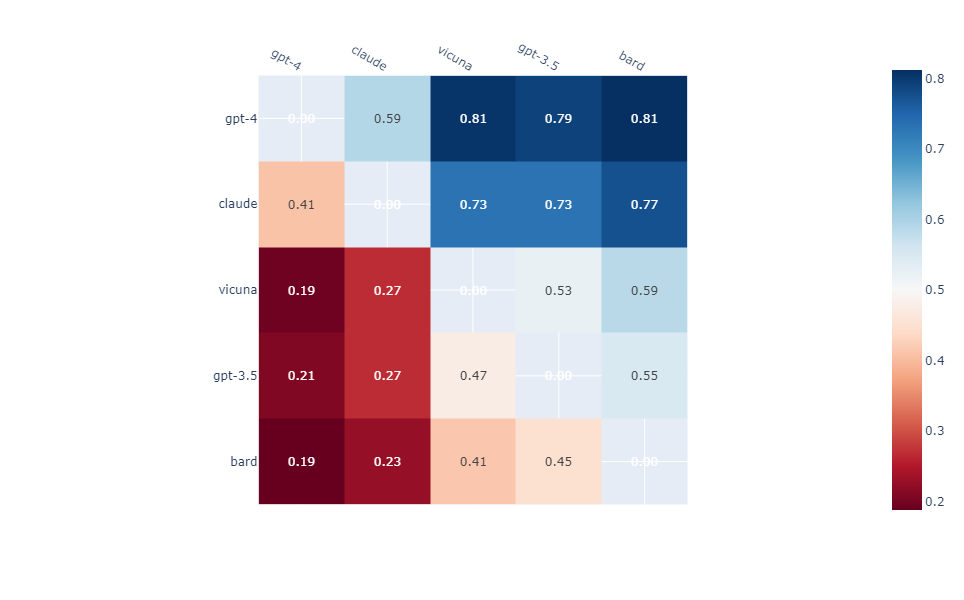

In [20]:
fig = visualize_pairwise_win_fraction(auto_reviews)
export_fig_as_html_and_pdf(fig, "all_heatmap")
fig.show()

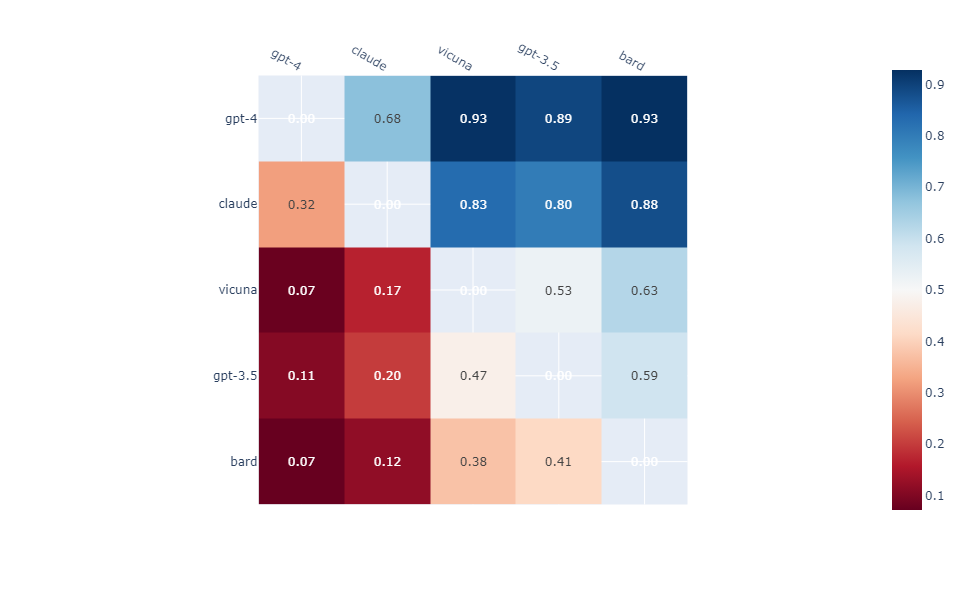

In [21]:
fig = visualize_pairwise_win_fraction(gpt4_reviews)
export_fig_as_html_and_pdf(fig, "gpt4_heatmap")
fig.show()

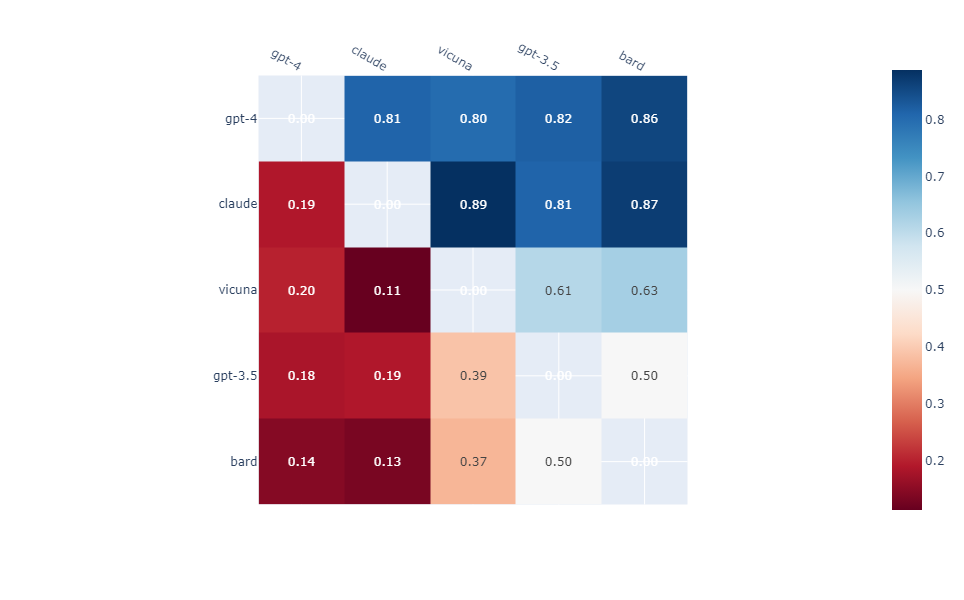

In [22]:
fig = visualize_pairwise_win_fraction(doubled_human_reviews)
export_fig_as_html_and_pdf(fig, "human_heatmap")
fig.show()

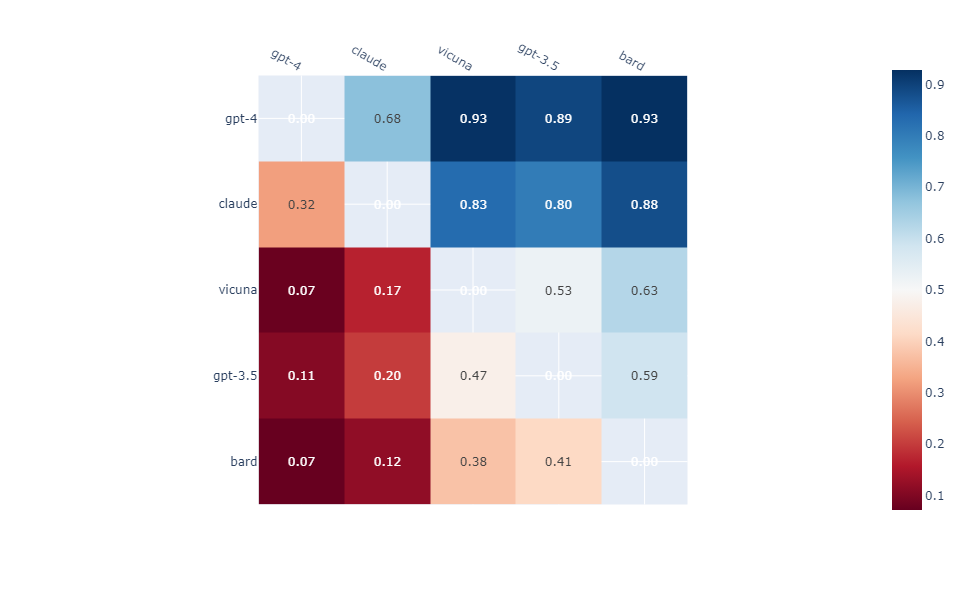

In [23]:
ws = normal_winrate(gpt4_reviews, 5)['weights']
wrs = compute_weighted_pairwise_win_fraction(gpt4_reviews, ws)
fig = visualize_pairwise(wrs)
fig.show()

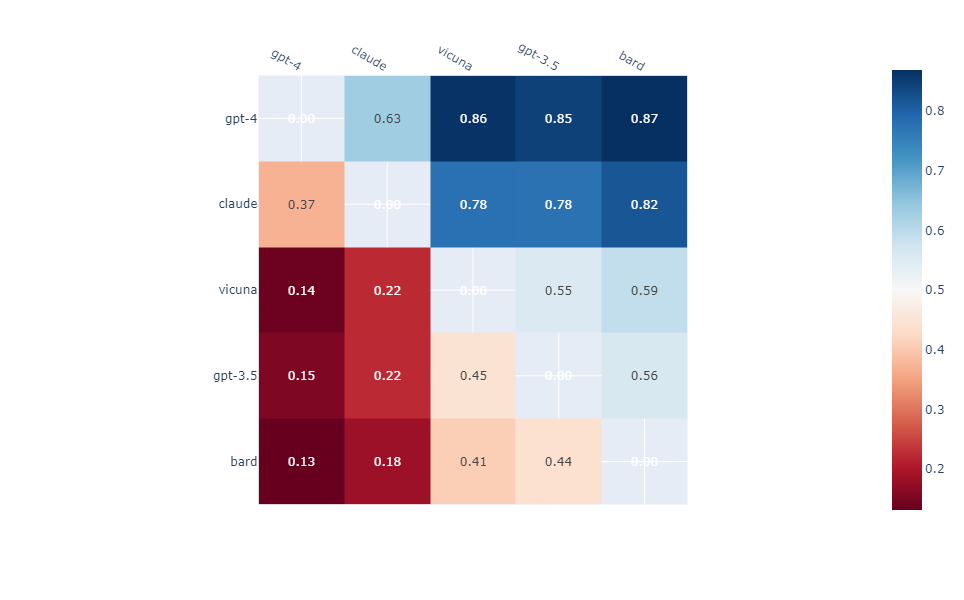

In [24]:
ws = normal_winrate(auto_reviews, 5)['weights']
wrs = compute_weighted_pairwise_win_fraction(auto_reviews, ws)
fig = visualize_pairwise(wrs)
export_fig_as_html_and_pdf(fig, "all_weighted_heatmap")
fig.show()

In [43]:
weights_df = pd.DataFrame([{'model': k, 'weight': v} for k, v in ws.items()])
weights_df
fig = px.pie(weights_df, values='weight', names='model', title='Weights assigned to each Reviewer', color_discrete_sequence=px.colors.qualitative.Pastel1)
fig = fig.update_layout(
    width=500,
    height=500,
)
export_fig_as_html_and_pdf(fig, "reviewer_weights")
fig.show()

,model,weight
0,bard,0.000000
1,gpt-4,0.488445
2,vicuna,0.081813
3,claude,0.376660
4,gpt-3.5,0.053081


## Chatbot Arena for comparison

In [4]:
# import gdown
# url = "https://drive.google.com/file/d/1gjs-APnGZjw8vmN5pwykV2SukS0KYE-z/view?usp=share_link"
# filename = gdown.download(url, quiet=False, fuzzy=True)

In [25]:
filename = '../data/vicuna80/clean_battle_20230522.json'
raw_data = pd.read_json(filename).sort_values(ascending=True, by=["tstamp"])


In [26]:
battles = raw_data[raw_data['anony']].reset_index(drop=True)
battles_no_ties = battles[~battles["win"].str.contains("tie")]
battle_name_map = {
    'vicuna-13b': 'vicuna',
    'gpt-4': 'gpt-4',
    'gpt-3.5-turbo': 'gpt-3.5',
    'claude-v1': 'claude',
    'palm-2': 'bard',
}
battles['model_a'] = battles['model_a'].map(battle_name_map)
battles['model_b'] = battles['model_b'].map(battle_name_map)
battles['score'] = battles['win'].map({'model_a': -1, 'tie': 0, 'model_b': 1})
battles['reviewer'] = None
battles.dropna(subset=['model_a', 'model_b', 'score'], inplace=True)

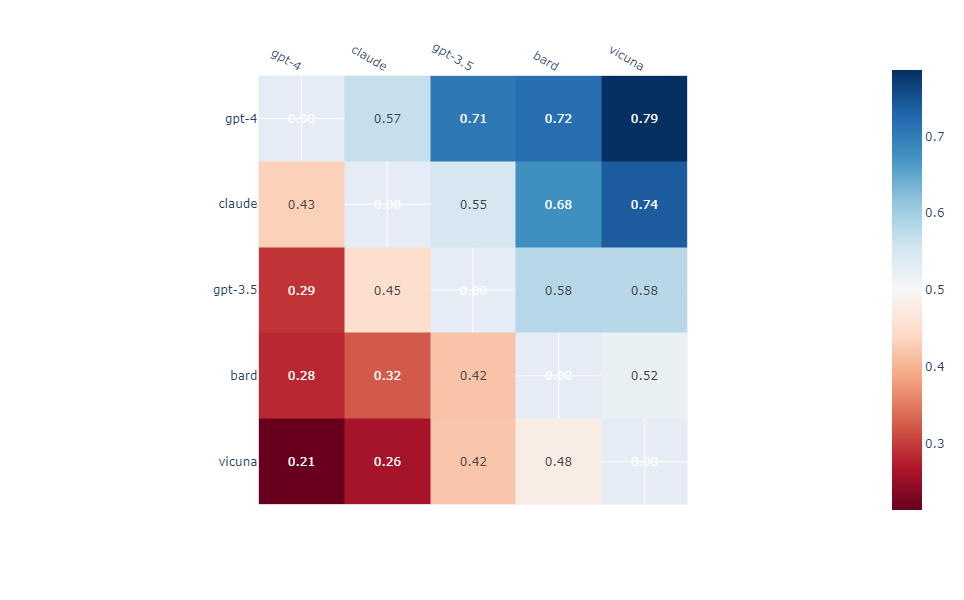

In [28]:
fig = visualize_pairwise_win_fraction(battles)
export_fig_as_html_and_pdf(fig, "arena_heatmap")
fig

# Elo Trends

In [47]:
# Functions for computing and showing Elotrends

# adapted from https://colab.research.google.com/drive/1lAQ9cKVErXI1rEYq7hTKNaCQ5Q8TzrI5?usp=sharing#scrollTo=hytEb0aXfcwm
def compute_elotrend(battles, reviewer_type, report_interval=1, K=32, SCALE=400, BASE=10, INIT_RATING=1000, weights=None):
    if weights is None:
        weights = defaultdict(lambda: 1)
    else:
        weights = get_norm(weights, op=lambda x: x, div_factor=pd.DataFrame.mean)
    rating = defaultdict(lambda: INIT_RATING)

    i = 0
    yield {'iteration': i, 'elo': rating, 'reviewer': reviewer_type}
    for rd, model_a, model_b, reviewer, score in battles[['model_a', 'model_b', 'reviewer', 'score']].itertuples():
        i += 1

        w = weights[reviewer]
        ra = rating[model_a]
        rb = rating[model_b]
        ea = 1 / (1 + BASE ** ((rb - ra) / SCALE))
        eb = 1 / (1 + BASE ** ((ra - rb) / SCALE))

        # score from scale of [-1, 1] corresponding to [model_a, model_b] wins
        sa = (1 - score) / 2

        if abs(score) > 1.001:
            print("problem @", model_a, model_b)
            raise Exception(f"unexpected vote {score}")
        rating[model_a] += w * K * (sa - ea)
        rating[model_b] += w * K * (1 - sa - eb)

        if i % report_interval == 0:
            yield {'iteration': i, 'elo': rating, 'reviewer': reviewer_type}

def compute_elotrends_for_model(model_name, report_interval, seed=73):
    hasmodel_reviews = auto_reviews[(auto_reviews.model_a == model_name) | (auto_reviews.model_b == model_name)]
    hasmodel_human_reviews = doubled_human_reviews[(doubled_human_reviews.model_a == model_name) | (doubled_human_reviews.model_b == model_name)]
    weights = normal_elo(hasmodel_reviews, 5)['weights']

    def replicate_df(df, ntimes):
        return pd.concat([df] * ntimes)

    d_gpt4_reviews = replicate_df(hasmodel_reviews[hasmodel_reviews.reviewer == 'gpt-4'], 5).sort_values(by=['question_id','model_a','model_b'])
    dd_human_reviews = replicate_df(hasmodel_human_reviews, 5).sort_values(by=['question_id','model_a','model_b'])
    hasmodel_reviews = hasmodel_reviews.sort_values(by=['question_id', 'model_a', 'model_b', 'reviewer'])
    rs=seed
    ri=report_interval

    def extract_model_elo(entry):
        return {**entry, 'elo': entry['elo'][model_name]}
    elotrend_df = pd.DataFrame(
      map(extract_model_elo,
          chain(compute_elotrend(d_gpt4_reviews.sample(frac=1, random_state=rs), 'GPT-4', report_interval=ri),
              compute_elotrend(dd_human_reviews.sample(frac=1, random_state=rs), 'Human', report_interval=ri),
              compute_elotrend(hasmodel_reviews.sample(frac=1, random_state=rs), 'All (weighted)', weights=weights, report_interval=ri),
          )
      )
    ).sort_values(by=['iteration'], ascending=False)
    return elotrend_df

def smooth(scalars: List[float] | np.ndarray, weight: float) -> List[float]:  # Weight between 0 and 1
    """Exponential Moving Average"""
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

def smooth_elos(elos_df, weight):
    def smooth_group(df):
        df = df.sort_values(by='iteration')
        elo_arr = df['elo'].to_numpy()
        smoothed_elos = smooth(elo_arr, weight)
        df['elo'] = smoothed_elos
        return df

    return elos_df.groupby('reviewer', as_index=False).apply(smooth_group)

def figure_for_elos(df, model_name, tick_interval=100):
    colorscheme = px.colors.qualitative.Safe
    fig = px.line(
        df, x="iteration", y="elo",
        title=f'Elo of {model_name.upper()} from various reviewers', color='reviewer',
        labels={
            'elo': 'Elo of GPT-4',
            'iteration': "Match No.",
            'reviewer': '',
        },
        color_discrete_map={
            'All (weighted)': colorscheme[0],
            'Human': colorscheme[1],
            'GPT-4': colorscheme[2],
        })

    fig.update_layout(
        xaxis = dict(
            tickmode = 'linear',
            tick0 = 0,
            dtick = tick_interval,
        ),
        legend=dict(
          yanchor="bottom",
          y=0.03,
          xanchor="right",
          x=0.98,
        ),
        width=800,
        height=600,
        plot_bgcolor="White"
    )
    fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
    fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
    return fig

def elotrend_master(model_name, interval=1, smooth=False, smooth_weight=0.99, seed=73):
    df = compute_elotrends_for_model(model_name, interval, seed=seed)
    if smooth:
        df = smooth_elos(df, weight=smooth_weight)
    fig = figure_for_elos(df, model_name, 100)
    export_fig_as_html_and_pdf(fig, f"{model_name}-elotrends-interval{interval}{'-smoothed' if smooth else ''}")
    fig.show()

In [48]:
elotrend_master('gpt-4', smooth=True)
elotrend_master('gpt-3.5', smooth=True)

# Agreement and Accuracy

In [49]:
def weighted_vote(df, weights=None, EPS=0.01):
    def take_weighted_wta_vote(frame):
        if weights is None:
            w = None
        else:
            w = frame['reviewer'].map(weights).values
        # weighted average of scores
        x = np.average(frame['score'], weights=w)
        # take sign of average
        y = np.where(x > EPS, 1, np.where(x < -EPS, -1, 0))
        return pd.Series(y, index=['score'])

    return df.groupby(['question_id', 'model_a', 'model_b'], as_index=False).apply(take_weighted_wta_vote)

In [50]:
def fleiss_kappa(*review_dfs):
    review_dfs = [df.sort_values(by=['question_id', 'model_a', 'model_b']) for df in review_dfs]

    scores = np.array([df['score'].values for df in review_dfs]).T
    subject_category_matrix = ir.aggregate_raters(scores)[0]
    return ir.fleiss_kappa(subject_category_matrix)

def accuracy(*review_dfs):
    review_dfs = [df.sort_values(by=['question_id', 'model_a', 'model_b']) for df in review_dfs]

    scores = np.array([df['score'].values for df in review_dfs])
    len_comparisons = scores.shape[1]

    comparisons = []
    num_comparisons = 0
    for i, ratingA in enumerate(scores):
        for j, ratingB in enumerate(scores):
            if i >= j:
                continue
            num_comparisons += 1
            comparisons.append(np.sum(ratingA == ratingB))

    return reduce(lambda x, y: x + y, comparisons) / (num_comparisons * len_comparisons)


In [51]:
def print_fleiss_and_accuracy(*review_dfs):
    print("Fleiss Kappa")
    print(fleiss_kappa(*review_dfs))
    print()
    print("Accuracy")
    print(accuracy(*review_dfs))
    print()

In [52]:
def compare_method_to_gold(auto_reviews, gold_reviews, weighting_func, iters=5):
    print(f"> FOR {weighting_func.__name__}")
    weights = weighting_func(auto_reviews, iters)['weights'] if iters > 0 else None
    reviews = weighted_vote(auto_reviews, weights=weights)
    print_fleiss_and_accuracy(reviews, gold_reviews)

In [53]:
def run_all(reviewers, iters):
    revs = filter_reviews_by_reviewers(auto_reviews, reviewers)
    compare_method_to_gold(revs, doubled_human_reviews, normal_winrate, iters=iters)
    compare_method_to_gold(revs, doubled_human_reviews, normal_elo, iters=iters)


In [54]:
run_all(['gpt-4', 'gpt-3.5', 'claude', 'vicuna', 'bard'], iters=5)

> FOR normal_winrate

Fleiss Kappa

0.40995961100205325



Accuracy

0.673125



> FOR normal_elo

Fleiss Kappa

0.3777350017392392



Accuracy

0.65375




In [55]:
run_all(['gpt-4', 'gpt-3.5', 'claude', 'vicuna', 'bard'], iters=1)

> FOR normal_winrate

Fleiss Kappa

0.40995961100205325



Accuracy

0.673125



> FOR normal_elo

Fleiss Kappa

0.3772767349897218



Accuracy

0.655




In [56]:
run_all(['gpt-4', 'gpt-3.5', 'claude'], iters=1)

> FOR normal_winrate

Fleiss Kappa

0.4030335797098367



Accuracy

0.665625



> FOR normal_elo

Fleiss Kappa

0.4030335797098367



Accuracy

0.665625




In [57]:
run_all(['gpt-4', 'gpt-3.5', 'claude'], iters=5)

> FOR normal_winrate

Fleiss Kappa

0.4030335797098367



Accuracy

0.665625



> FOR normal_elo

Fleiss Kappa

0.4030335797098367



Accuracy

0.665625




In [58]:
def run_one_reviewer(reviewer):
    reviews = auto_reviews[auto_reviews.reviewer == reviewer]
    print_fleiss_and_accuracy(reviews, doubled_human_reviews)

In [59]:
run_one_reviewer('gpt-4')

Fleiss Kappa

0.4062941127626006



Accuracy

0.6425




In [60]:
run_one_reviewer('claude')

Fleiss Kappa

0.31943600558165275



Accuracy

0.606875




In [61]:
run_one_reviewer('gpt-3.5')

Fleiss Kappa

0.3873768855885963



Accuracy

0.620625




In [62]:
gv_models = ['vicuna', 'gpt-3.5']
gpt35_vs_vicuna_auto = filter_reviews_by_models(auto_reviews, gv_models)
gpt35_vs_vicuna_human = filter_reviews_by_models(doubled_human_reviews, gv_models)

In [63]:
# gpt4
print_fleiss_and_accuracy(
    filter_reviews_by_reviewers(gpt35_vs_vicuna_auto, ['gpt-4']),
    gpt35_vs_vicuna_human)

Fleiss Kappa

0.10386709039992445



Accuracy

0.44375




In [64]:
# gpt-3.5
print_fleiss_and_accuracy(
    filter_reviews_by_reviewers(gpt35_vs_vicuna_auto, ['gpt-3.5']),
    gpt35_vs_vicuna_human)

Fleiss Kappa

0.1920892068167473



Accuracy

0.475




In [65]:
# all unweighted
def null_weights(*args, **kwargs):
    return {'weights': None}
compare_method_to_gold(gpt35_vs_vicuna_auto, gpt35_vs_vicuna_human, null_weights, iters=5)

> FOR null_weights

Fleiss Kappa

0.1475430882305742



Accuracy

0.48125




In [66]:
def seed_with(f, seed):
    def g(reviews, iters):
        return f(reviews, iters, seed=seed)
    g.__name__ = f.__name__
    return g

# all weighted with different seeds
for i in range(10):
    compare_method_to_gold(gpt35_vs_vicuna_auto, gpt35_vs_vicuna_human, seed_with(normal_elo, i), iters=10)

# most of the time it returns the lower accuracy score and it is hard to recover the higher accuracy score

> FOR normal_elo

Fleiss Kappa

0.05904119998678421



Accuracy

0.44375



> FOR normal_elo

Fleiss Kappa

0.2412874727987267



Accuracy

0.54375



> FOR normal_elo

Fleiss Kappa

0.05904119998678421



Accuracy

0.44375



> FOR normal_elo

Fleiss Kappa

0.05904119998678421



Accuracy

0.44375



> FOR normal_elo

Fleiss Kappa

0.05904119998678421



Accuracy

0.44375



> FOR normal_elo

Fleiss Kappa

0.05904119998678421



Accuracy

0.44375



> FOR normal_elo

Fleiss Kappa

0.05904119998678421



Accuracy

0.44375



> FOR normal_elo

Fleiss Kappa

0.2412874727987267



Accuracy

0.54375



> FOR normal_elo

Fleiss Kappa

0.2412874727987267



Accuracy

0.54375



> FOR normal_elo

Fleiss Kappa

0.05904119998678421



Accuracy

0.44375


